In [1]:
!pwd

/Users/carlosgranados/Desktop/MachineLearning/NN_model/SIIM


In [2]:
# TO RUN WITH GOOGLE DRIVE DATA

# from google.colab import drive
# drive.mount('/content/drive')

# SIIM-ISIC MELANOMA CLASSIFICATION 

****
## Preprocessing

Meta data on samples is loaded into the meta_train and meta_test dataframes. Categorical columns are label encoded for both simultaneously, and missing values are replaced by column averages.

Image data is extracted from TFRecord files and will be preprocessed separately.

In [5]:
# LOAD LIBRARIES
import numpy as np, pandas as pd, os
import matplotlib.pyplot as plt, cv2
from sklearn.impute import SimpleImputer
import tensorflow as tf, re, math
import random,time

meta_train = pd.read_csv('train.csv')
meta_test =pd.read_csv('test.csv')#/drive/My Drive/SIIM_data/test.csv
sample_sub = pd.read_csv('sample_submission.csv')

y = meta_train.target

# COMBINE TRAIN AND TEST TO ENCODE TOGETHER
cols = meta_test.columns
comb = pd.concat([meta_train[cols],meta_test[cols]],ignore_index=True,axis=0).reset_index(drop=True)

# LABEL ENCODE ALL STRINGS
cats = ['patient_id','sex','anatom_site_general_challenge'] 
for c in cats:
    comb[c],mp = comb[c].factorize()
    #print(mp)
#print('Imputing Age NaN count =',comb.age_approx.isnull().sum())
comb.age_approx.fillna(comb.age_approx.mean(),inplace=True)
comb['age_approx'] = comb.age_approx.astype('int')

# REWRITE DATA TO DATAFRAMES
meta_train[cols] = comb.loc[:meta_train.shape[0]-1,cols].values
meta_test[cols] = comb.loc[meta_train.shape[0]:,cols].values
meta_train.diagnosis.value_counts()

unknown                               27124
nevus                                  5193
melanoma                                584
seborrheic keratosis                    135
lentigo NOS                              44
lichenoid keratosis                      37
solar lentigo                             7
cafe-au-lait macule                       1
atypical melanocytic proliferation        1
Name: diagnosis, dtype: int64

****

## Training with Logistic Regression in scikit-learn

As first step we train a common model with the original meta data features.
We get the score for the model's performance and set it as our first base score.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc

X = meta_train[cols]

X.drop(["image_name"], axis=1, inplace=True)#X.drop(["image_name", "patient_id"], axis=1, inplace=True)#

# Train-validation split

X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.2, test_size=0.2, random_state=0)
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

# Predict probability target
y_pred_p = clf.predict_proba(X_val)

/Users/carlosgranados/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### Optimize F_1 score
The model is then evaluated with its F_1 score instead of accuracy which overlooks the skewness in the data set.

In [7]:
prob_thr = np.arange(0.01,0.13,0.001)
f1_scores = []
for pt in prob_thr:
    y_predict = [1 if a[1]>=pt else 0 for a in y_pred_p ]
    f1_scores.append(f1_score(y_val, y_predict))
    #print(y_predict.count(1), f1_score(y_val, y_predict), pt )
max_f1 = np.max(f1_scores) 
c_pt = prob_thr[f1_scores.index(max_f1)]

print('max f1_score:%s'%max_f1, '\ndiscrimination threshold :%s%%'%(np.round(c_pt*100)))
y_predict = [1 if a[1]>=c_pt else 0 for a in y_pred_p ]


max f1_score:0.13937282229965156 
discrimination threshold :6.0%


### ROC and AUC score
The ROC curve compares the number of true positive results to that of false negatives as the discrimination threshold is changed.
We use the area under the ROC curve (AUC), as the scoring metric to grade our models.


AUC:0.69515


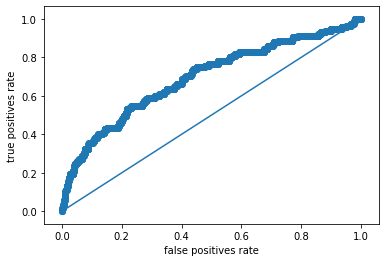

In [8]:
y_pred_p[:,1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_p[:,1], pos_label=None)
plt.scatter(fpr,tpr)
plt.xlabel('false positives rate')
plt.ylabel('true positives rate')
plt.plot(fpr,fpr)
print('AUC:%s'%np.round(auc(fpr, tpr),5))

****

### Test for submission

In [9]:
X_test = meta_test[cols]

X_test.drop(["image_name"], axis=1, inplace=True)

y_test_p = clf.predict_proba(X_test)

sample_sub.target = y_test_p[:,1]

sample_sub.to_csv("submission.csv", index=False)

sample_sub.tail()

,image_name,target
10977,ISIC_9992485,0.045068
10978,ISIC_9996992,0.031084
10979,ISIC_9997917,0.024728
10980,ISIC_9998234,0.102496
10981,ISIC_9999302,0.030066


*****

## Training with Keras model in TensorFlow

Anticipating the use of neural networks for the image classifier stage of the project, one can start practicing  by training one with the raw metadata.

#### Loss function

To use a loss fuction for F_1 score one uses the functional for of F_1 but with float type arguments. See [here](https://www.kaggle.com/rejpalcz/best-loss-function-for-f1-score-metric) for explanation.

In [10]:
# Customize loss functions

import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical

# F_1 Score:

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)#K.round(y_pre[:,1])
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1[-1:])

def f1_loss(y_true, y_pred):
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1[-1:])

In [14]:
X_NN = X
X_NN.drop(['patient_id'], axis=1, inplace=True)
X.head()

/Users/carlosgranados/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3994: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,sex,age_approx,anatom_site_general_challenge
0,0,45,0
1,1,45,1
2,1,50,2
3,1,45,0
4,1,55,1


In [15]:
#Build and compile model

from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model

y_binary = to_categorical(y) #Encode target

X_train, X_val, y_train, y_val = train_test_split(X_NN, y_binary, train_size=0.8, test_size=0.2, random_state=0)

input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(5, activation='relu')(input_layer)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)
output = Dense(y_binary.shape[1], activation='softmax')(dense_layer_1)#(input_layer)#

model = Model(inputs=input_layer, outputs=output)
model.compile(loss=f1_loss, optimizer='adam', metrics=['acc', f1])
print(model.summary())
#print(model.compile.__doc__)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 12        
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
history = model.fit(X_train, y_train, batch_size=200, epochs=100, verbose=0, validation_split=0.3)

In [17]:
# Validate

score = model.evaluate(X_val, y_val, verbose=1)
y_p = model.predict(X_val)

#y_true, y_pred = np.argmax(y_val, axis=1), np.argmax(y_p, axis=1)

#plt.scatter(X_val['age_approx'],y_pred)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])
print("F_1 score:",  f1(y_val, y_p).numpy())

6626/6626 [==============================] - 1s 79us/sample - loss: 0.9427 - acc: 0.9179 - f1: 0.0568
Test Score: 0.9426515696094074
Test Accuracy: 0.9178992
F_1 score: 0.087248296


AUC score:0.6873952441687311


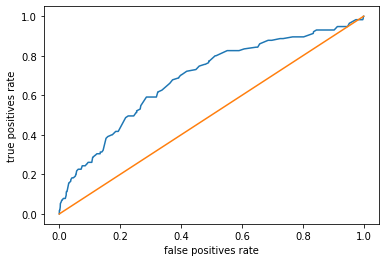

In [18]:
# ROC and AUC score
y_val_pos = [a[1] for a in y_val ]
y_p_pos = [a[1] for a in y_p ]

fpr, tpr, thresholds = roc_curve(y_val_pos, y_p_pos, pos_label=None)

plt.xlabel('false positives rate')
plt.ylabel('true positives rate')
plt.plot(fpr,tpr)
plt.plot(fpr,fpr)
print("AUC score:%s"%auc(fpr, tpr))


In [ ]:
# # check target
# ct=0
# for a in y_p:
#     ct+=1
#     if a[1]>=0.5:
#         print(a,ct, y_val[ct-1])


****
## Image Preprocessing



### Working with tfrec files

Images are extracted from tfrec files provided by the competition.

#### Functions for reading TFRecord  files

See verify Tfrecord section of [this notebook](https://www.kaggle.com/cdeotte/how-to-create-tfrecords)

In [19]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "image_name": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        "target": tf.io.FixedLenFeature([], tf.int64)
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = example['image_name']
    target = example['target']
    return image, label, target # returns a dataset of (image, label) pairs

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [20]:
# INITIALIZE VARIABLES
IMAGE_SIZE= [1024,1024]; BATCH_SIZE = 1
AUTO = tf.data.experimental.AUTOTUNE
TRAINING_FILENAMES = tf.io.gfile.glob('train*.tfrec')
print('There are %i train images'%count_data_items(TRAINING_FILENAMES))

There are 4142 train images


#### Display Train Images

The extracted images along metadata provided by TFRecord files are orderly loaded into the image, label and target arrays.  

In [21]:
# LOAD FILES INFO INTO ARRAYS
t0 = time.time()

dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
image = []
label = []
target = []

counter=0
for image_features in dataset.take(3000):
  counter +=1
  #print(counter)
  image.append(image_features[0].numpy())
  label.append(image_features[1].numpy().decode("utf-8"))
  target.append(image_features[2].numpy())

t1 = time.time()

print(t1-t0)

231.00183415412903


In [22]:
# SPLITING POSITIVE AND NEGATIVE TARGETS
unique, counts = np.unique(target, return_counts=True)
dict(zip(unique, counts))
p_indx = [i for i in range(len(target)) if target[i] == 1] 
n_indx = [i for i in range(len(target)) if target[i] == 0]
print('positive target indexes:',p_indx)

positive target indexes: [19, 148, 176, 194, 208, 243, 254, 288, 436, 448, 548, 554, 641, 689, 732, 771, 805, 906, 991, 993, 1025, 1140, 1155, 1298, 1490, 1513, 1540, 1555, 1583, 1629, 1699, 1728, 1863, 1886, 2049, 2176, 2431, 2445, 2481, 2501, 2558, 2626, 2635, 2678, 2717, 2803, 2826, 2952]


POSITIVE DIAGNOSIS


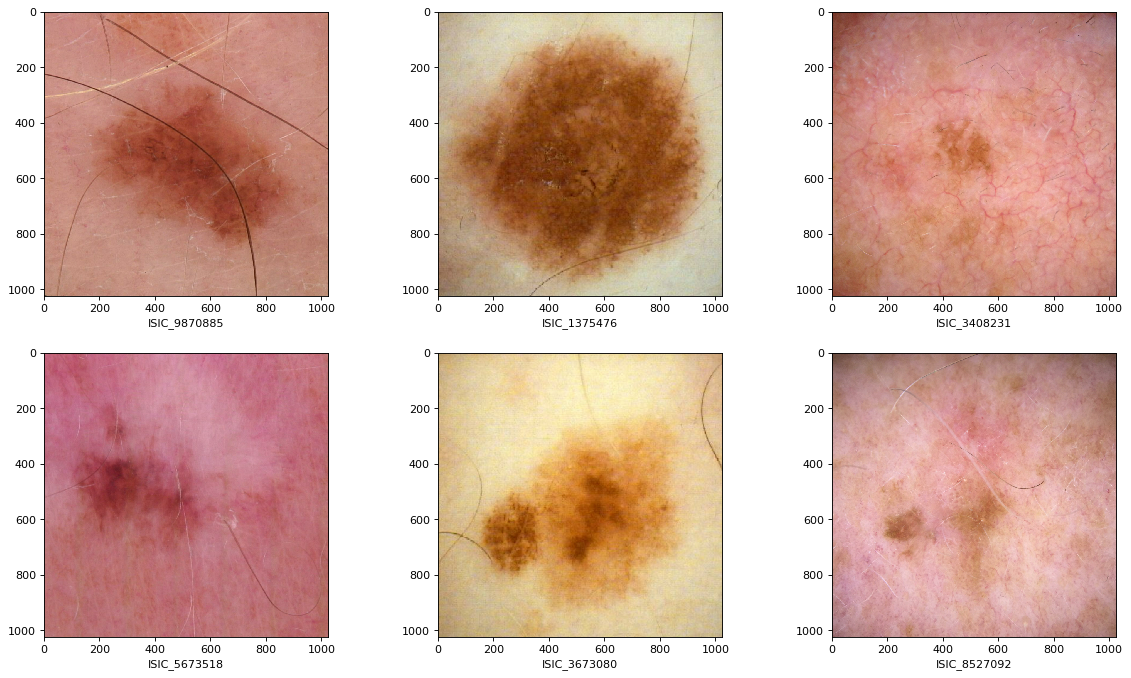

NEGATIVE DIAGNOSIS


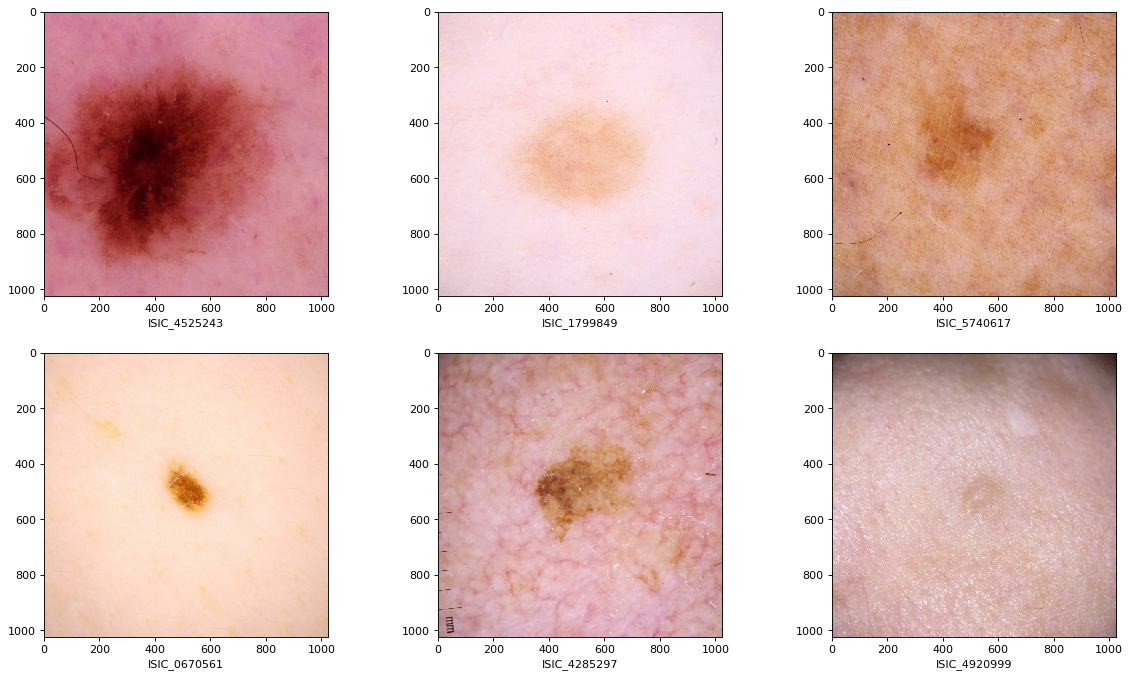

In [23]:
# Display positive targets in sample
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
site = int(330)

for i in random.sample(p_indx, 6):
  site = int(site+1)
  plt.subplot(int(site))
  plt.xlabel(label[i])
  plt.imshow(image[i])
print('POSITIVE DIAGNOSIS')

# Display negative targets in sample
plt.show()
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
site = int(330)
for i in random.sample(n_indx, 6):
  site = int(site+1)
  plt.subplot(int(site))
  plt.xlabel(label[i])
  plt.imshow(image[i])
print('=====================================================================================================',
      '\nNEGATIVE DIAGNOSIS')
plt.show()

## Searching for contours and contour properties

OpenCv will be used here to extract features from images. 

These features relate to properties of contuors drawn on each image and tuned to approximately correspond to the injured region. Geometric features such as area and perimeter will be later rescaled to mitigate unknown differences on origigal image sizes.

The functions in the cell below will be used to extract contour features and to display contours on top of each image.
See various sections of [this manual](https://opencv-python-tutroals.readthedocs.io/en/latest/index.html)

### Function menu

These functions will be applied to images within the data set and to countours within each image in order to select the right set of contours from the ones initially obtained though direct application of the OpenCV tool cv2.findContours. Among the problems arising from the direct use of this tool for this particular data set which may lead to extracting the wrong set contours are:

- hair lines in picture
- scales
- marker lines
- peripheral shadow

The first two are addresed using cv2.morphologyEx while the last two may be solved by imposing a centrality condition on the contours centroids. This is done inside the main function draw_contours(image)



In [24]:
import cv2
# FINDING AND DRAWING THE RIGHT CONTOURS 

def cnt_area(cnt):
    # returns area enclosed by contour cnt
    return cv2.contourArea(cnt)

def perimeter(cnt):
    return cv2.arcLength(cnt,True)

def complexity(cnts):
    complexity = []
    for cnt in cnts:
        cmpl = (perimeter(cnt))**2/(4.0*np.pi*cnt_area(cnt))
        complexity.append(cmpl)
    return complexity
   

def ave_intensity(cnt,image):
  # Returns average intensity in region enclosed by contour cnt
    mask = np.zeros(image.shape[:2], dtype="uint8") * 255
    mask1 = cv2.drawContours(mask,cnt,0,255,-1)
    return cv2.mean(image,mask = mask1)

def reduce_img(image,cnts):
    mask = np.ones(image.shape[:2], dtype="uint8") * 255
    cv2.drawContours(mask, cnts, -1, 0, -1)
    image_r = cv2.bitwise_and(image, image, mask=mask)
    return image_r, cv2.mean(image_r)

def in_out_ratios(image,cnts):
    _, out_mean = reduce_img(image,cnts)
    ratios = []
    for cnt in cnts:
        cnt_r = [ave_intensity(cnt,image)[i]/out_mean[i] for i in range(3)]
        ratios.append(cnt_r)
    return ratios


def centroids(cnt):
    # Returns centroid coordinates for contour cnt
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    return [cx,cy]


def draw_contours(image):

    # Return imposed selected coutour images, their mean intensity and enclosed area
    # Intends to capture region(s) of interest
    #_______________________  

    # Remove hair from image
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (18,18))
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    #-----------------------

    imr =(255*image).astype(np.uint8)

    # Convert RGB to BGR 
    im = imr[:, :, ::-1].copy() 

    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)

    #ret,thresh = cv2.threshold(imgray,80,255,0)
    ret,thresh = cv2.threshold(imgray,0,255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)#_SIMPLE)#

    #edged = cv2.Canny(imgray, 30, 200) 
    #contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
  
    cnts = contours[:]
    mask = np.zeros(imgray.shape,np.uint8)

    # Removing small contours
    cnts0 = [cnt for cnt in contours if cnt_area(cnt)>12000]
    #-------------------------

    # Removing contours too close to edges
     
    cnts1 = [cnt for cnt in cnts0 if 200<centroids(cnt)[0]<800]
    cnts2 = [cnt for cnt in cnts1 if 200<centroids(cnt)[1]<800]
    cnts = [cnt for cnt in cnts2 if complexity([cnt])[0]<10 or len(cnts1)==1]# ]#100<centroids(cnt)[0]<900]
   
    #-------------------------

    # filling contours mean intensity and area

    mean_val=[]
    area_val=[]
  
    for cnt in cnts:
        mask1 = cv2.drawContours(mask,cnt,0,255,-1)
        mean_val.append(max(ave_intensity(cnt,imgray)))
        area_val.append(cnt_area(cnt))

    #min_int = np.min(mean_val)
    #min_indx = mean_val.index(min_int)
    #------------------------------

    # Imposing contours on image
    img = cv2.drawContours(imr, cnts, -1, (0,255,0), 3)

    return img, cnts, hierarchy, mean_val, area_val


CONTOURS FOR POSITIVE DIAGNOSIS:


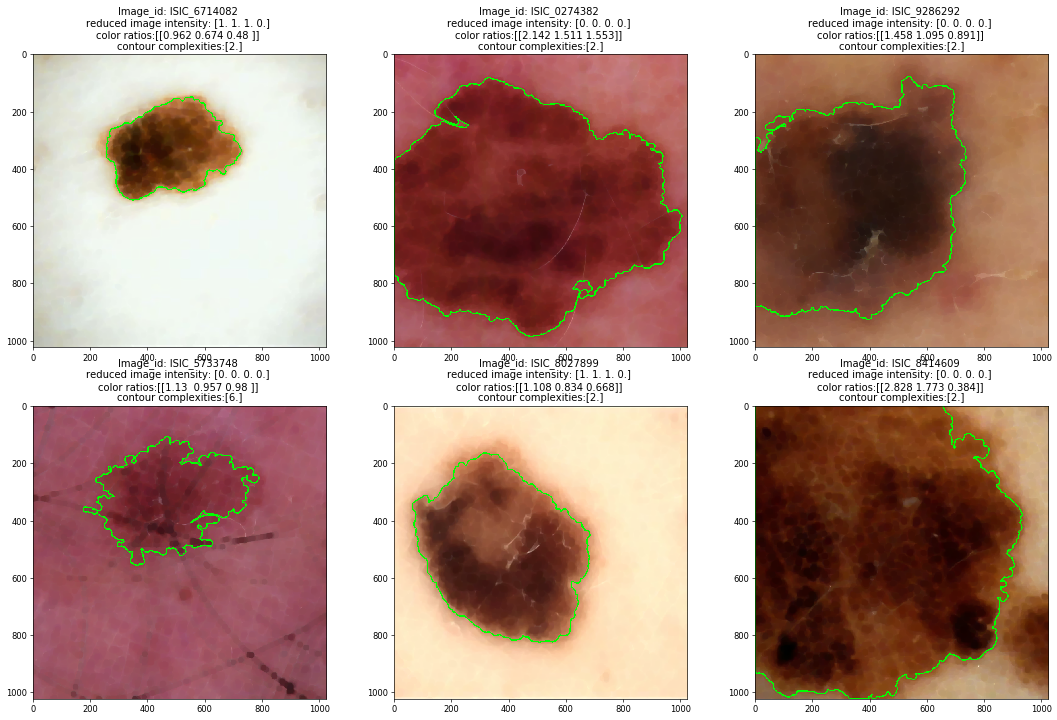

CONTOURS FOR NEGATIVE DIAGNOSIS:


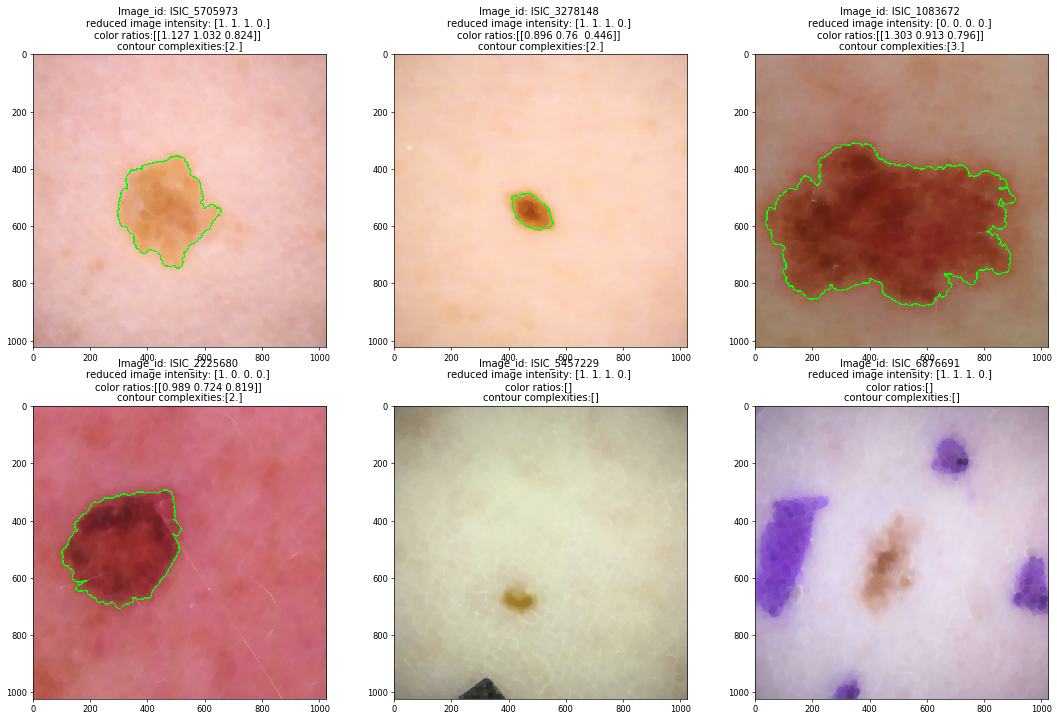

12.292547225952148


In [25]:
t0=time.time()
a=40
b=a+6

# DISPLAY POSITIVES WITH CONTOURS
fig=plt.figure(figsize=(22, 22), dpi= 60, facecolor='w', edgecolor='k')
site = int(330)
for i in p_indx[a:b]:#random.sample(p_indx, 6):
    site = int(site+1)
    plt.subplot(int(site))
    
    img,cnts,_,mean_val,area_val = draw_contours(image[i])
    _,mean_int = reduce_img(image[i],cnts)
    ratios = in_out_ratios(255*image[i],cnts)
    complexities = complexity(cnts) 
#     print('Image_id: %s \nreduced image intensity: %s \ncolor ratios:%s \ncontour complexities:%s'
#           %(label[i],np.round(mean_int),np.round(ratios,3), np.round(complexities)))
    plt.title('Image_id: %s \nreduced image intensity: %s \ncolor ratios:%s \ncontour complexities:%s'
          %(label[i],np.round(mean_int),np.round(ratios,3), np.round(complexities)))

#     plt.title('Image_id: %s \nContour intensities: %s \nContour areas: %s'
#                %(label[i], mean_val, area_val))
    plt.imshow(img)

print('\nCONTOURS FOR POSITIVE DIAGNOSIS:')
plt.show()
#------------------------------------------------------------------

# DISPLAY NEGATIVES WITH CONTOURS    
    
fig=plt.figure(figsize=(22, 22), dpi= 60, facecolor='w', edgecolor='k')
site = int(330)
for i in n_indx[a:b]:#random.sample(n_indx, 6):
    site = int(site+1)
    plt.subplot(int(site))
    
    img,cnts,_,mean_val,area_val = draw_contours(image[i])
    _,mean_int = reduce_img(image[i],cnts)
    ratios = in_out_ratios(255*image[i],cnts)
    complexities = complexity(cnts) 
#     print('Image_id: %s \nreduced image intensity: %s \ncolor ratios:%s \ncontour complexities:%s'
#           %(label[i],np.round(mean_int),np.round(ratios,3), np.round(complexities)))
    plt.title('Image_id: %s \nreduced image intensity: %s \ncolor ratios:%s \ncontour complexities:%s'
          %(label[i],np.round(mean_int),np.round(ratios,3), np.round(complexities)))

#     plt.title('Image_id: %s \nContour intensities: %s \nContour areas: %s'
#                %(label[i], mean_val, area_val))
    plt.imshow(img)

print('=====================================================================================================',
      '\nCONTOURS FOR NEGATIVE DIAGNOSIS:')
plt.show()

t1=time.time()
print(t1-t0)
#np.shape(ratios)
# red_ratio = [ratio[0] for ratio in ratios]
# print(ratios,'\n',red_ratio)

### Creating new image-based features
Below, we load arrays with image features created from the image's contour content and properties computed using the functions on the menu of the section above. 
It is apparent that the geometry of the lesion and the color contrast with its sorroundings tend to be more dramatic for positive samples. Base on this, we will built features using  area, perimeter, gray and color intensities of the regions enclosed by the set of contours:  

In [26]:

# 
t0=time.time()

N_contours = []

# GEOMETRY

total_perimeter = []
max_area = []
total_area = []
max_complexity = []
mean_complexity = []
#-----------------------
# GRAY PROFILE
in_gray_mean = []
out_gray = []
#-----------------------
# COLOR RGB PROFILE
in_red_mean = []
out_red = []
in_green_mean = []
out_green = []
in_blue_mean = []
out_blue = []
#-----------------------
# COLOR RATIOS

mean_red_ratio = []
mean_green_ratio =[]
mean_blue_ratio = []
counter = 0
#-----------------------

for im in image[:]:
    
#     counter = counter+1
#     print(counter)
    _, cnts, _, mean_val, area_val = draw_contours(im)
    N_contours.append(len(cnts))
    
    # GEOMETRY
    total_perimeter.append(np.sum([perimeter(cnt) for cnt in cnts]))
        
    max_area.append(np.max(area_val  +[0]))
    total_area.append(np.sum(area_val))
    max_complexity.append(np.max(complexity(cnts)+[0]))
    mean_complexity.append(np.mean(complexity(cnts)))
    #-------------------------------------------------
    
    # GRAY PROFILE
    imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    in_gray_w = np.sum([area_val[i]*mean_val[i]/np.sum(area_val) for i in range(len(cnts))])
    in_gray_mean.append(in_gray_w/255)
    
    _, out_gry = reduce_img(imgray,cnts)
    out_gray.append(max(out_gry))
    
    #-------------------------------------------------
    
    # COLOR RGB PROFILE
    in_clr_mean = [sum([area_val[i]*ave_intensity(cnts[i],im)[j]/np.sum(area_val)
                   for i in range(len(cnts))]) for j in range(3) ]
    
    in_red_mean.append(in_clr_mean[0])
    in_green_mean.append(in_clr_mean[1])
    in_blue_mean.append(in_clr_mean[2])
    
    _, out_clr = reduce_img(im,cnts)
    
    out_red.append((out_clr[0]))
    out_green.append((out_clr[0]))
    out_blue.append((out_clr[0]))
    
    #-------------------------------------------------
    
    # Color ratios(inside/outside contour)
    ratios = in_out_ratios(255*im,cnts)
    ratio_w = [[area_val[i]*ratios[i][j]/np.sum(area_val) for i in range(len(cnts))]for j in range(3)]
    mean_red_ratio.append(np.sum(ratio_w[0]))     
    mean_green_ratio.append(np.sum(ratio_w[1]))
    mean_blue_ratio.append(np.sum(ratio_w[2])) 
    
t1=time.time()

print(t1-t0)

/Users/carlosgranados/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/carlosgranados/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1329.3611068725586


In [27]:
# Rescale geometric features
max_area = max_area/np.mean(max_area)
total_area = total_area/np.mean(total_area)
total_perimeter = total_perimeter/np.mean(total_perimeter)


In [28]:
# test dataframe
toy_db = pd.DataFrame(data={'image_name': label, 'N_contours': N_contours, 'total_perimeter': total_perimeter, 
                            'max_area':max_area, 'total_area': total_area, 
                            'max_complexity': max_complexity,'mean_complexity': mean_complexity,
                            'in_gray_mean': in_gray_mean, 'out_gray': out_gray,
                            'in_red_mean': in_red_mean, 'out_red': out_red,
                            'in_green_mean': in_green_mean, 'out_green': out_green,
                            'in_blue_mean': in_blue_mean, 'out_blue': out_blue,
                            'mean_red_ratio': mean_red_ratio, 'mean_green_ratio': mean_green_ratio,
                            'mean_blue_ratio': mean_blue_ratio,'target':target})

toy_db.head()

,image_name,N_contours,total_perimeter,max_area,total_area,max_complexity,mean_complexity,in_gray_mean,out_gray,in_red_mean,out_red,in_green_mean,out_green,in_blue_mean,out_blue,mean_red_ratio,mean_green_ratio,mean_blue_ratio,target
0,ISIC_3139230,1,0.848634,0.740750,0.732165,2.538106,2.538106,0.411765,0.370706,0.643137,0.585276,0.274510,0.585276,0.337255,0.585276,1.098861,0.843546,0.892697,0
1,ISIC_3812493,1,0.477115,0.213838,0.211360,2.779081,2.779081,0.819608,0.753189,0.949020,0.907824,0.709804,0.907824,0.635294,0.907824,1.045378,0.964262,0.872946,0
2,ISIC_1939931,1,0.230577,0.094085,0.092994,1.475211,1.475211,0.792157,0.749401,0.917647,0.898204,0.717647,0.898204,0.603922,0.898204,1.021647,0.978924,0.833370,0
3,ISIC_0818550,1,0.320480,0.188653,0.186466,1.421283,1.421283,0.827451,0.892705,0.964706,0.958608,0.756863,0.958608,0.631373,0.958608,1.006361,0.867459,0.695931,0
4,ISIC_8681290,1,1.657790,2.187072,2.161724,3.280472,3.280472,0.701961,0.535046,0.878431,0.577630,0.647059,0.577630,0.427451,0.577630,1.520752,1.173114,0.878871,0


mean_complexity_ave(pos): 3.62    mean_complexity_ave(neg): 3.27
mean_complexity_std(pos): 1.83    mean_complexity_std(neg): 2.86
total_area_ave(pos): 2.0    total_area_ave(neg): 0.98
total_area_std(pos): 1.83    total_area_std(neg): 2.86


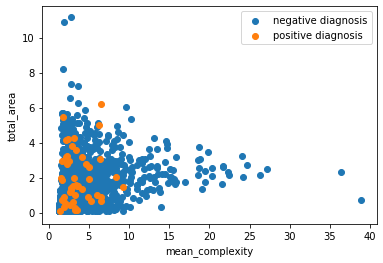

In [29]:
# Visualize Features

x_l, y_l = 'mean_complexity', 'total_area'
plot_1=toy_db.loc[toy_db.target ==1]
plot_0=toy_db.loc[toy_db.target ==0]

x1, y1 = plot_1[x_l], plot_1[y_l]
x0, y0 = plot_0[x_l], plot_0[y_l]

#plt.xlim(0,5)
#plt.ylim(0,4)

print('%s_ave(pos): %s    %s_ave(neg): %s'%(x_l, round(np.mean(x1),2),x_l, round(np.mean(x0),2)))

print('%s_std(pos): %s    %s_std(neg): %s'%(x_l, round(np.std(x1),2),x_l, round(np.std(x0),2)))

print('%s_ave(pos): %s    %s_ave(neg): %s'%(y_l, round(np.mean(y1),2),y_l, round(np.mean(y0),2)))

print('%s_std(pos): %s    %s_std(neg): %s'%(y_l, round(np.std(x1),2), y_l, round(np.std(x0),2)))

neg_plt = plt.scatter(x0,y0, marker="o", label = 'negative diagnosis')
pos_plt = plt.scatter(x1,y1, marker='o', label = 'positive diagnosis')
plt.legend(handles=[neg_plt, pos_plt])
#plt.hlines(y_av0,0,1)
#plt.hlines(y_av1,0,1)
plt.xlabel(x_l)
plt.ylabel(y_l)
plt.show()

In [30]:
y = toy_db.target
X = toy_db.copy()
X.drop(['image_name', 'target'], axis = 1, inplace=True)#,'N_contours','max_complexity','mean_complexity','N_contours','mean_complexity',
        #'max_complexity', 'max_area']
#X = pd.DataFrame(toy_db.total_area)

# Fill NaN entries
for col in X.columns:
    X[col].fillna(X[col].mean(),inplace=True)

In [31]:
#print(xgb.XGBClassifier.__doc__)

#### Train Models with new features

AUC:0.7149


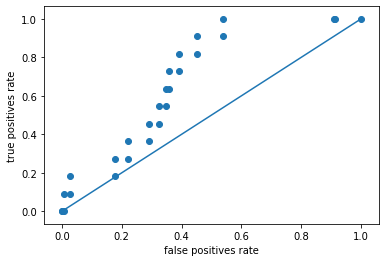

In [72]:
# Train Logistic Regressor
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=0)
clf2 = LogisticRegression(random_state=0, max_iter = 100).fit(X_train, y_train)

# Predict probability target
y_pred_p = clf2.predict_proba(X_val)
y_p = list(y_pred_p[:,1])


fpr, tpr, thresholds = roc_curve(y_val,y_p, pos_label=None)
plt.scatter(fpr,tpr)
plt.xlabel('false positives rate')
plt.ylabel('true positives rate')
plt.plot(fpr,fpr)
print('AUC:%s'%np.round(auc(fpr, tpr),5))

In [73]:

import xgboost as xgb
from xgboost import XGBClassifier,plot_importance
D_train = xgb.DMatrix(X_train, label = y_train)
D_val = xgb.DMatrix(X_val, label = y_val)
  
param = {
    'eta': 0.3, 
    'alpha':0.0,
    #'delta':0.1,
    'max_depth':9,  
    'objective': 'multi:softprob', 
    'gamma': 0.00,
    'num_class': 2} 

steps = 20  # The number of training iterations

model = xgb.train(param, D_train, steps)

preds = model.predict(D_val)
fpr, tpr, thresholds = roc_curve(y_val, preds[:,1], pos_label=None)
print('AUC:%s'%np.round(auc(fpr, tpr),5))

AUC:0.81297


AUC:0.81297


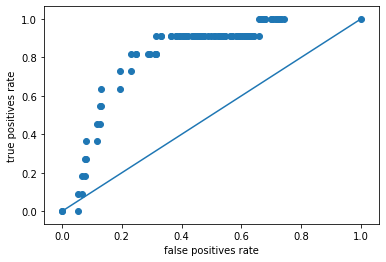

In [74]:

plt.scatter(fpr,tpr)
plt.xlabel('false positives rate')
plt.ylabel('true positives rate')
plt.plot(fpr,fpr)
print('AUC:%s'%np.round(auc(fpr, tpr),5))

[0.         0.05056496 0.08175135 0.08465488 0.07156402 0.0899812
 0.08631704 0.09790149 0.0641885  0.06740227 0.08038296 0.
 0.0847322  0.         0.05454043 0.02157611 0.06444266]


Index(['N_contours', 'total_perimeter', 'max_area', 'total_area',
       'max_complexity', 'mean_complexity', 'in_gray_mean', 'out_gray',
       'in_red_mean', 'out_red', 'in_green_mean', 'out_green', 'in_blue_mean',
       'out_blue', 'mean_red_ratio', 'mean_green_ratio', 'mean_blue_ratio'],
      dtype='object')

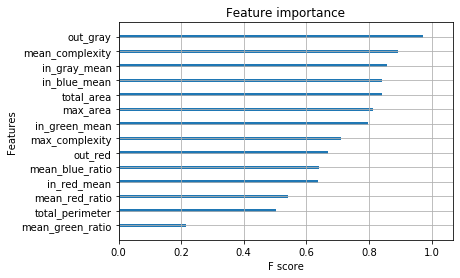

In [75]:
model = XGBClassifier()
model.fit(X_train, y_train)
# feature importance
print(model.feature_importances_)
# plot feature importance
plot_importance(model, importance_type='gain', show_values=False)
X.columns